# Natural Language Processing for the Fake News Challenge

## Main Imports

In [1]:
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

from joblib import dump, load
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion, make_pipeline, make_union
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense

!pip install transformers
import transformers

Mounted at /content/drive
     |████████████████████████████████| 2.1MB 9.9MB/s 
     |████████████████████████████████| 3.3MB 40.2MB/s 
     |████████████████████████████████| 901kB 39.4MB/s 


## Set up the data for preprocessing
### Load and sample the data

In [2]:
main_path = '/content/drive/My Drive/University Work/Year 4/Natural Language Processing/'
data_folder_name = 'data'
train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'

train_body_path = main_path + data_folder_name +'/'+ train_body_filename 
train_stance_path = main_path + data_folder_name + '/' + train_stance_filename

body_data = pd.read_csv(train_body_path)
stance_data = pd.read_csv(train_stance_path)

In [4]:
body_data.sample(10)

,Body ID,articleBody
65,99,"Shane Smith, the sometimes controversial but a..."
148,228,Sex-selecting abortions are nothing new. They ...
661,1000,An animal shelter is trying to track down the ...
723,1084,The Pentagon said Friday that it had confirmed...
25,35,"New Delhi: AK Verma, an executive engineer at ..."
815,1224,ISIS released a video purportedly showing the ...
270,425,Rep. Duncan Hunter (R-Calif.) said Tuesday nig...
1285,1933,At least not anytime soon\n\nThe internet has ...
17,24,Macaulay Culkin is not dead. The actor is just...
645,977,Supporters of Islamic State have claimed that ...


### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies

In [5]:
total_data = pd.merge(body_data, stance_data, on='Body ID')

# add relevance column
total_data['Relevance'] = np.where(total_data['Stance'] == 'unrelated', 0, 1)
total_data.sample(10)

,Body ID,articleBody,Headline,Stance,Relevance
11780,704,With Christian Bale already secured to play th...,Islamic State using 'SCORPION bombs' to terror...,unrelated,0
46108,2362,Banksy has not been arrested. Let's not bury t...,Met police denies reports of Banksy arrest,agree,1
1991,115,Afghanistan veteran Sam Arnold uploaded this s...,Six months after abducting Nigerian schoolgirl...,unrelated,0
44105,2287,CNN has released new audio tonight in the Mich...,Government fires employee who skipped work for...,unrelated,0
22630,1311,Two Australian men claim to have the oldest bu...,World's oldest burger,discuss,1
8385,524,Apple would never lower itself to rubbing elbo...,ISLAMIC STATE BEHEADS MISSING AMERICAN JOURNAL...,unrelated,0
13344,800,"Well, here’s the creepiest thing you’ll read a...","Boko Haram denies truce, says kidnapped girls ...",unrelated,0
33203,1828,Another nun who had no idea that she was pregn...,"Nun gives birth, intends to keep baby",discuss,1
8181,516,A married Russian TV star woke up one day to d...,Will King of Jordan lead airstrikes on ISIS HI...,unrelated,0
24247,1379,The video texting service Glide has verified t...,Man Chops Off and Throws Away His Small Penis ...,unrelated,0


### Splitting the dataset into train and validation sets

In [6]:
input_columns = total_data[['Headline', 'articleBody']]
target = 'Relevance'
X_train, X_val, y_train, y_val = train_test_split(input_columns, total_data[target].values , test_size=0.20, random_state=0)

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)

X_train.sample(10)

Size of training set: (39977, 2)
Size of validation set: (9995, 2)


,Headline,articleBody
9687,BREAKING NEWS: British-born U.S. photojournali...,(CNN) -- Scratch Christian Bale off the list o...
14919,Confusion as Cuba’s Castro mourned instead of ...,The sister of British-born American photojourn...
10284,Rapper identified as James Foley's executioner...,Knightscope co-founder Stacy Stephens said rum...
34324,ISIS leader dead?,A video which supposedly proves that TBS speed...
36686,Second person rushed to hospital with Ebola sy...,Mounted with a cannon and leaving a trail of s...
44865,A bunch of cool health features were cut from ...,The Pentagon has confirmed that the weapons we...
38468,Alleged audio of Michael Brown shooting has su...,A married TV actor who met a young woman and k...
1560,Pentagon: ISIS seized materials airdropped to ...,Share this: \t\nSeven year old superhero abili...
47233,AWESOME! Canadian Parliament’s Sergeant-at-Arm...,Canadian media reports say that shots have bee...
10672,Lynch Mob Castrates Alleged Rapist In Rajasthan,An Indian man had his penis cut off with a mea...


## TF-IDF Feature Extraction
### Custom Transformer for Pipeline

In [26]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

### Pipelines and Feature Union of Headline and Article Body
- Apply fit transform

In [27]:
# feature extraction with TF-IDF

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=200, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=200, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
train = preprocessor.fit_transform(X_train).todense()
val = preprocessor.transform(X_val).todense()
print('Train size: ', train.shape)
print('Val size: ', val.shape)

Train size:  (39977, 400)
Val size:  (9995, 400)


## Evaluation Metrics

### Confusion Matrix

In [7]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [8]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Display the Confusion Matrix and ROC Curve results

In [25]:
def display_results(model, val, y_val):

    y_pred = model.predict(val)

    print(metrics.classification_report(y_val, y_pred))
    plot_confusion_matrix(y_val, y_pred)

    # convert to 0s and 1s for plotting ROC curve
    roc_y_val = [np.int64(1) if i == 'related' else np.int64(0) for i in y_val]
    roc_y_pred = [np.int64(1) if i == 'related' else np.int64(0) for i in y_pred]

    plot_roc_curve(roc_y_val, roc_y_pred)

## Machine Learning Models

### Support Vector Machine Classifier

In [ ]:
def train_SVM(train, y_train, extractor):

    start = time.time()
    parameters = {
        'C': [1, 10],
        'gamma': [1, 'auto', 'scale']
    }
    # Tune hyperparameters  using Grid Search and a SVM model
    model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1).fit(train, y_train)
    dump(model, extractor + '_SVM.joblib')

    end = time.time()
    print("Training took", end - start, "seconds")

    return model

### Train SVM using TF-IDF Features and display results

In [ ]:
model = train_SVM(train, y_train, "tfidf")

Training took 6708.22327542305 seconds


              precision    recall  f1-score   support

     related       0.90      0.87      0.89      2767
   unrelated       0.95      0.96      0.96      7228

    accuracy                           0.94      9995
   macro avg       0.93      0.92      0.92      9995
weighted avg       0.94      0.94      0.94      9995



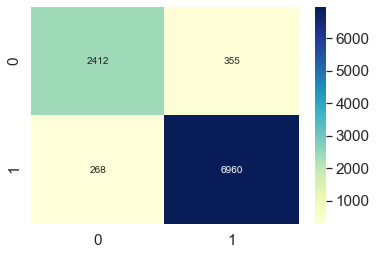

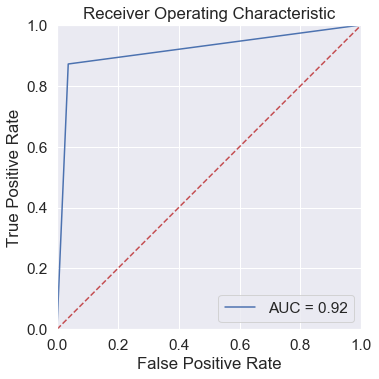

In [ ]:
display_results(model, val, y_val)

# Tokenisation with BERT

### Load the model and tokeniser

In [17]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                    transformers.DistilBertTokenizer,
                                                    'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

### Embedding Retrieval

In [18]:
def get_embeddings(data, batch_size):

    # set device and lambda function for classification token retrieval
    device = torch.device("cuda")
    get_cls = lambda x: x[0][:, 0, :].squeeze()
    bert_embeddings = []  # initialise embeddings

    for i in range(batch_size, data.shape[0] + batch_size, batch_size):
    
        if i % 100 == 0:
            print("Batch", i)
        
        # tokenise
        tokenized = tokenizer(list(data['Headline'][i - batch_size:i]), list(data['articleBody'][i - batch_size:i]),\
                          padding='max_length', truncation=True, return_tensors="pt")
        
        # get input ids and set to device
        tokenized_text = tokenized['input_ids']
        tokenized_text = tokenized_text.to(device)

        # calculate embeddings and retrieve cls token embedding
        with torch.no_grad():
            embeddings = model(tokenized_text)
        cls_embeddings = get_cls(embeddings)

        # append to total embeddings
        if bert_embeddings == []:
            bert_embeddings = cls_embeddings
        else:
            bert_embeddings = torch.cat((bert_embeddings, cls_embeddings), 0)

        # clear cache and GPU memory
        del embeddings
        torch.cuda.empty_cache()

    return bert_embeddings

In [19]:
device = torch.device("cuda")
model = model.to(device)
batch_size = 256

print("Training Set")
train = get_embeddings(X_train, batch_size)
torch.save(train, main_path + 'bert_train.pt')

print("Testing Set")
val = get_embeddings(X_val, batch_size)
torch.save(val, main_path + 'bert_val.pt')

Training Set
Batch 6400
Batch 12800
Batch 19200
Batch 25600
Batch 32000
Batch 38400
Testing Set
Batch 6400


In [34]:
train = torch.load(main_path + 'bert_train.pt')
val = torch.load(main_path + 'bert_val.pt')

In [20]:
model = SVC(kernel='rbf').fit(train.cpu(), y_train)

In [37]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=5000).fit(train.cpu(), y_train)
clf.score(val.cpu(), y_val)

0.8590295147573787

### Train SVM using BERT Embeddings and display results

In [ ]:
model = train_SVM(train.cpu(), y_train, 'bert')

9995 9995
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      7228
           1       0.92      0.11      0.19      2767

    accuracy                           0.75      9995
   macro avg       0.83      0.55      0.52      9995
weighted avg       0.79      0.75      0.67      9995



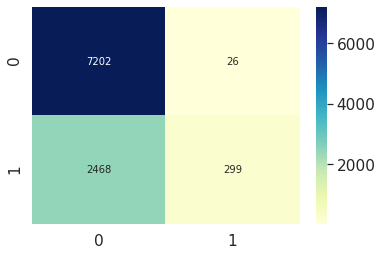

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


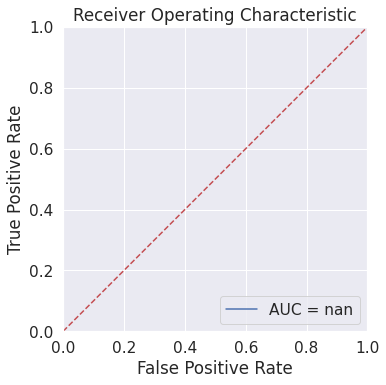

In [38]:
print(len(val), len(y_val))
display_results(model, val.cpu(), y_val)

              precision    recall  f1-score   support

           0       0.74      0.97      0.84      7228
           1       0.61      0.13      0.21      2767

    accuracy                           0.74      9995
   macro avg       0.68      0.55      0.53      9995
weighted avg       0.71      0.74      0.67      9995



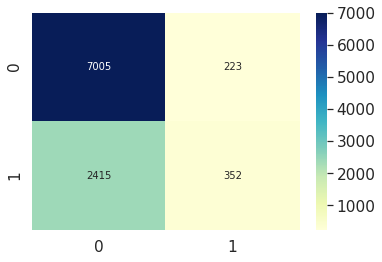

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


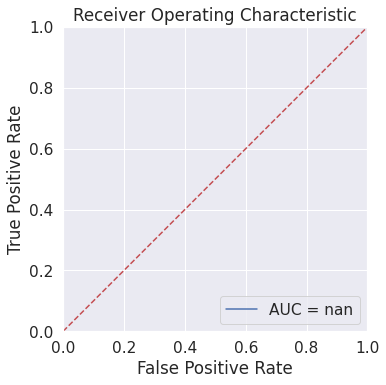

In [30]:
display_results(clf, val, y_val)

## Deep Learning Models

### Long Short-Term Memory (LSTM)

In [ ]:
embed_dim = 200
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(LSTM(units=400, input_shape=train.shape, return_sequences=True))
#model.add(Embedding(train.shape[0], embed_dim, input_length = train.shape[1]))
model.add(LSTM(units=6, return_sequences=True))
#model.add(LSTM(lstm_out))
model.add(Dense(1, activation='softmax', name='output'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 39977, 400)        1281600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 39977, 6)          9768      
_________________________________________________________________
output (Dense)               (None, 39977, 1)          7         
Total params: 1,291,375
Trainable params: 1,291,375
Non-trainable params: 0
_________________________________________________________________
None


### Training

In [ ]:
model.fit(train, y_train, batch_size=batch_size, epochs=2, verbose=5)

Epoch 1/2


ValueError: ignored

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7228
           1       0.28      1.00      0.43      2767

    accuracy                           0.28      9995
   macro avg       0.14      0.50      0.22      9995
weighted avg       0.08      0.28      0.12      9995



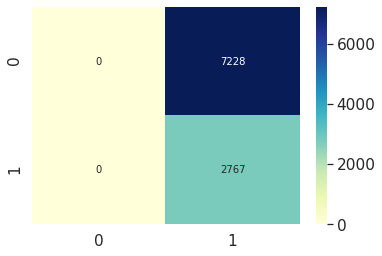

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


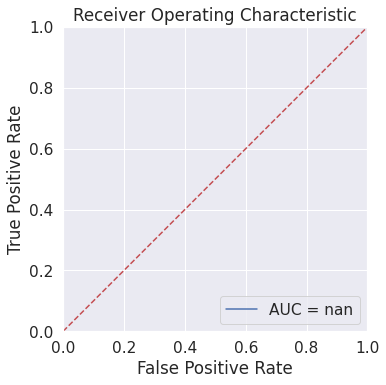

In [ ]:
display_results(model, val, y_val)

### Initialise and train